# Advanced Machine Learning: Assignment 4

Nome e cognome: Confalonieri Riccardo <br>
Matricola: 830404<br>
E-mail: r.confalonieri5@campus.unimib.it

## Transfer Learning
<p align = 'justify'>
Implement the transfer learning approach using a CNN pretrained on ImageNet, the suggested architecture is the VGG16. The CNN should be used as fixed feature extractor on a new task of your choice containing a number of classes in the range from $2$ to $10$, in particular it is required to consider threed different cutting point and discuss the results for each choice.  <br>
<p/>

<p align='justify'>
Il dataset utilizzato per svolgere questo assignment è stato preso da <a href='https://www.kaggle.com/puneet6060/intel-image-classification'>Kaggle</a> e contiene $6$ differenti classi, alcune delle quali presenti anche nel task originale di imagenet (e.g. sea, mountain):
<ol>
<li>buildings </li>
<li> forest</li>
<li>glacier</li>
<li>mountain</li>
<li>sea</li>
<li>street</li>
</ol>

In particolare il dataset è suddiviso in tre cartelle: training, test e prediction le prime due sono composte a loro volta da sottocartelle diverse il cui nome corrisponde alla label dell'immagine. Si utilizzerà quindi un opportuno data loader per caricare in memoria queste immagini, si segnala che la cartella prediction non verrà utilizzata in quanto contiene immagini senza la corrispettiva label e quindi non è utile ai fini dell'esercizio in quanto non si possono valutare le predizioni. <br>
Si segnala inoltre che il dataset contiene $14k+$ per il traning e $3k+$ per il test, ognuna di dimension $150x150$. Per semplificare il task e velocizzare la classificazione soltanto una piccola parte di queste immagini verrà effettivamente caricata, verranno utilizzate circa $500$ immagini per classe nel traninig set e $300$ per classe nel test set. Questo accorgimento permette inoltre di gestire meglio la memoria e velocizzare anche la predizione sfruttando i layer del modello VGG16.

Per quanto riguarda la fase di predizione si è optato per utilizzare un classificatore semplice, una SVM con kernel rbf. In questo modo si è evitato di trainare nuove reti neurali ad hoc che potrebbero essere fin troppo performanti rispetto al task che vogliamo risolvere e quindi non evidenziare differenze rispetto ai punti di cut scelti.
</p>

### Import packages

In [2]:
# for get data folder
from google.colab import drive
# keras
from tensorflow import keras

# pre trained model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# for dimensionality reduction
from sklearn.decomposition import PCA

# for loading and unzip dataset
import zipfile
from shutil import copyfile
import os
# for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

### Loading data
<p align='justify'>
<b> Disclaimer: </b> Il modo in cui ho importato il dataset non è sicuramente il migliore in quanto carica subito tutte le immagini in memoria, sarebbe stato meglio utilizzare metodi alternativi che caricando i dati in modo più opportuno. Si è scelta questa opzione per semplicità e velocità nell'eseguire le manipolazioni successive sui dati. <br>

Carico il dataset da google drive utilizzando delle librerie apposite per copiare e unzippare il file zip.
</p>

In [3]:
# Mount drive and set folder path
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment4/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# loading dataset and unzipping into the root
copyfile(drive_path + 'archive.zip', 'archive.zip')
with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall("archive")

<p align='justify'>
Per caricare le immagini definisco una funzione apposita che ritorna la lista di immagini e la corrispondente lista di label. Si poteva utilizzare anche la funzione preposta di Keras per caricare questo tipo di struttura, tuttavia in questo caso le immagini sarebbero state di tipo proprietario e quindi sarebbe stato necessario applicare ulteriori passaggi per convertirle a lista (codice di importazione comunque disponibile commentato nelle celle sottostanti). <br>
Dato che per semplicità, nei passi successivi, si è deciso di applicare un semplice classificatore SVM si è preferito questo tipo di caricamento handwritten che richiede qualche secondo in più piuttosto che dover gestire un tipo proprietario. Al contrario se si risolvesse il nuovo task di classificazione con una neural network sarebbe più semplice e veloce utilizzare la funzione preposta di keras. 
</p>

In [2]:
# function for loading images from the structured folder
# basedir = external directory
# lst_subdir = list of subdirectory names
# img_size = size of images for reshaping
# n_examples = n. of example to load for each class
# Shuffle = true if shuffling data is needed
def load_imgs(base_dir, lst_subdir, img_size, n_examples, shuffle = True):
  X = []
  Y = []
  # iterate over each subdirectory
  for class_name in lst_subdir:
    # get all image in each directory
    for img in os.listdir(base_dir + class_name):
      path = os.path.join(base_dir + class_name, img)
      # get class label as number
      Y.append(lst_subdir.index(class_name))
      # load image and resize to match vgg16 dimension
      X.append(image.img_to_array(image.load_img(path, target_size=img_size)))

      # load only 800 example per class
      if (len(Y)%n_examples == 0):
        break

  # convert to numpy array
  X = np.array(X)
  Y = np.array(Y)

  # shuffling data
  idx = np.random.permutation(len(X))
  X, Y = X[idx], Y[idx]
  return X, Y

In [3]:
lst_subdir = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
# loading training data 
x_train, y_train = load_imgs('archive/seg_train/seg_train/', lst_subdir, 
                             (224,224), 500)
# loading test data
x_test, y_test = load_imgs('archive/seg_test/seg_test/', lst_subdir, (224,224), 300)

In [6]:
# informazioni di base sul dataset
print('Tipo delle immagini:', type(x_train))
print('Numero di esempi di training:', len(x_train))
print('Numero di label per il training:', len(y_train))
print("Dimensione dell'immagine: " + str(x_train[0].shape) )
print("Range di valori dell'immagine ["+ str(x_train[0].min()) + "," 
      + str(x_train[0].max()) + "]")
print("Tipo dei valori dell'immagine: ", type(x_train[0][0,0,0]))

Tipo delle immagini: <class 'numpy.ndarray'>
Numero di esempi di training: 3000
Numero di label per il training: 3000
Dimensione dell'immagine: (224, 224, 3)
Range di valori dell'immagine [0.0,255.0]
Tipo dei valori dell'immagine:  <class 'numpy.float32'>


Visualizzo tutte le possibili classi di appartenenza presenti nel dataset. 

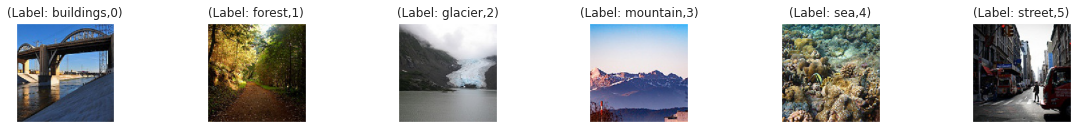

In [7]:
# Base idea = https://stackoverflow.com/questions/53837545/plotting-mnist-samples

plt.figure(figsize=(20, 4))
# visualizzo tutte e 10 le classi presenti nel dataset
for i in range(6):
  idx = np.argwhere(y_train == i)[0,0]
  ax = plt.subplot(2, 6, i + 1)
  # colormap = gray for better visualization
  plt.imshow(x_train[idx]/255.)
  # add label title
  plt.title("(Label: " + str(lst_subdir[y_train[idx]]) + "," + str(y_train[idx])+ ")")
  # remove axis from visualization
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

<p align='justify'>
Il dataset contiene anche una cartella con delle immagini senza la label definita per effettuare le predizioni, in questo caso non carico queste immagini perchè non conoscendo la label non posso effettuare alcuna verifica sull'accuratezza del modello creato.
</p>

### Loading VGG16
Carico il modello pre-trainato VGG16 a partire da questo modello nelle sezioni successive definirò dei sottomodelli con punti di cutting diversi. In questo modo analizzerò il comportamento della classificazione sfruttando la rappresentazione delle features generata dal modello fino a quel layer.

In [4]:
# get VGG16 base model
base_model = VGG16(weights='imagenet')
# print summary for check layer names
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<p align='justify'>
Applico quindi lo stesso preprocessing effettuato da VGG16 alle immagini caricate in precedenza. Lo applico già sia al training che al test set.
</p>

In [5]:
# preprocess image as in VGG16
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

### Feature extractor: fc1
<p align='justify'>
Il primo cutting point che analizzerò è stato effettuato dopo il primo layer fully connected, quindi con una rappresentazione molto elevata delle features, q
questo è ideale quanto il nuovo dataset è piccolo ma molto simile ad ImageNet. Nel nostro caso stiamo classificando dei paesaggi, molti dei quali sono già compresi nel primo task di imagenet (e.g. spiagge, montagne) quindi mi aspetto che tagliando la rete in un punto molto alto riesca ad ottenere delle buone performance.
</p>

In [10]:
# I start with cutting at a very high point, after the first fully connected layer
model_cut1 = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
model_cut1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<p align='justify'>
Questo modello è caratterizzato da un <b>numero molto alto di parametri trainabili</b> mentre le features di rappresenzazione dell'immagine, essendo estratte dal layer fully connected, sono $4096$ e quindi sono un numero che può essere gestito anche senza l'applicazione della PCA.
Utilizzo quindi un semplice classificatore a partire da queste features per risolvere il nuovo task.
</p>

In [11]:
start_time = time.time()
# extract feature for training set
features = model_cut1.predict(x_train)
# saving time for prediction
time_pred = (time.time() - start_time)

# extract feature for test set
features_test = model_cut1.predict(x_test)

# check features shape (we should have 4096 features for each image)
print(features.shape)

(3000, 4096)


<p align='justify'>
Addestro il classificatore SVM sfruttando la grid search per la ricerca dei migliori iperparametri. In particolare permetto a gamma di variare tra le due scelte di default: gamma e scale, senza quindi settare un valore decimale, mentre permetto al parametro di regolarizzazione C di variare tra $1,5$ o $10$. Tali valori resteranno gli stessi, per semplicità, anche per i classificatori SVM che verranno implementati negli step successivi. Si segnala inoltre che questi valori sono stati scelti dopo alcuni tentativi su questa primo cutting point e potrebbero quindi non essere i migliori per le successive scelte. <br>
Inoltre per come è implementata la grid search, all'interno della libreria sklearn, viene in automatico applicata una cross validation con 5 fold.
</p>

In [18]:
# possibile parameters for grid search
param_grid = {'C': [1, 5, 10], 'gamma': ['auto', 'scale']}

# define a SVM with gridsearch
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

start_time = time.time()

# fitting with training features
clf = clf.fit(features, y_train)
# saving time for fitting
fit_time = (time.time() - start_time)

# check score for training set
print('Parametri trovati con GridSearchCV:', clf.best_params_)
print('Score raggiunto sul training set:', round(clf.best_score_, 4))

Parametri trovati con GridSearchCV: {'C': 10, 'gamma': 'scale'}
Score raggiunto sul training set: 0.9213


In [6]:
# function to make and evaluate prediction given a classifier, a set of features and real labels
def evaluate_prediction(clf, features, y_hat):
  # predicting label for test set, using features extracted before
  y_pred = clf.predict(features)
  # print report
  print(classification_report(y_pred, y_hat))

  # get confusion matrix
  cm = confusion_matrix(y_pred, y_hat)

  # plot beautiful confusion matrix
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu");  

  ax.set_xlabel('True labels'); ax.set_ylabel('Predicted labels'); 
  ax.set_title('Confusion Matrix'); 

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       311
           1       0.99      0.99      0.99       299
           2       0.85      0.85      0.85       301
           3       0.84      0.89      0.86       285
           4       0.96      0.96      0.96       300
           5       0.93      0.92      0.93       304

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



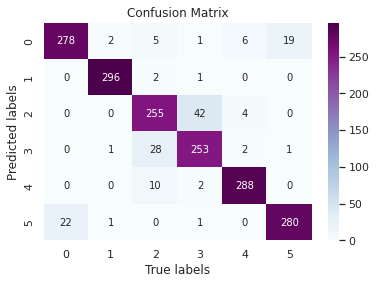

In [14]:
# evaluate prediction
evaluate_prediction(clf, features_test, y_test)

In [15]:
print('Tempo necessario per la creazione delle features:', round(time_pred,2), 'secondi')
print('Tempo necessario per il fitting del SVM:', round(fit_time,2), 'secondi')

Tempo necessario per la creazione delle features: 85.18 secondi
Tempo necessario per il fitting del SVM: 137.71 secondi


<p align='justify'>
Possiamo notare come il tempo per la creazione delle features e per il fitting sia molto alto. Per il primo non possiamo agire direttamente mentre possiamo provare ad ridurre la dimensionalità delle features per semplificare il classificatore e quindi ridurre i tempi. <br>
Andando oltre questa problematica possiamo notare come la classificazione sia buona e raggiunga score molto elevati uguali a quelli ottenuti nel training, con errori soprattutto nella classificazione delle classi $2$ e $3$ (montagne e ghiacciai) che vengono erroneamente scambiate tra loro. Tuttavia come si può verificare dal plotting delle immagini proposto nelle prime sezioni queste classi contengono immagini molto simili che può essere difficile distinguere.
</p>

#### PCA
<p align='justify'>
Come si è visto gestire $4096$ features è possibile e dà buoni risultati, tuttavia richiede un tempo considerevole sia per definire le features sul training set sia per fittare il modello SVM più appropiato. Per questo motivo provo ad applicare già in questo caso una dimensionality reduction per cercare di diminuire questi tempi.
</p>

In [24]:
# idea from:
# https://medium.com/predict/dimensionality-reduction-using-python-principal-component-analysis-fb365f39ae5c
# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


# function to check pca cumulative explained variance in order to decide how much
# features to keep
def check_pca(features):
  # copy=False is needed for saving memory with the others cutting point
  pca = PCA(n_components=min(features.shape[0], features.shape[1]), copy=False)
  pca.fit(features)

  plt.figure(figsize=(15, 4))
  cum_sum = np.cumsum(pca.explained_variance_ratio_)
  plt.plot(cum_sum)
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance')
  plt.show()

  # for saving memory space
  del pca

  return cum_sum

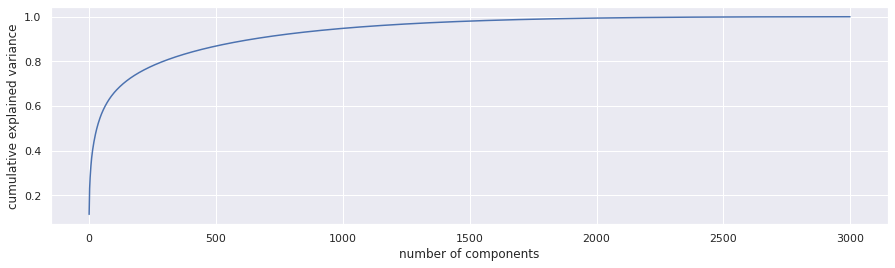

In [25]:
   # plotting pca cumulative explained variance
_ = check_pca(features)

<p align='justify'>
Dall'andamento del grafico si nota che con $500$ si riesce a spiegare oltre l'$80\%$ della varianza dei dati, mentre gia con $1500$ su $3000$ si raggiunge il $100\%$. Provo allora ad effettuare effettivamente la PCA mantenendo solo $500$ elementi e verificare nuovamente il risultato della classificazione. La PCA verrà trainata e fittata inizialmente sul training set, successivamente la stessa PCA verrà applicata al test set. <br>
Lo stesso procedimento può essere effettuato in maniera più semplice ed immediata sfruttando opportunamente i parametri della PCA(), è infatti possibile inserire un valore compreso tra $[0,1]$ ad indicare la percentuale di varianza che vogliamo spiegare, in questo modo il numero ottimale di componenti sarà dedotto in automatico.

In [26]:
start_time = time.time()

# define pca to keep only 500 components
pca = PCA(n_components=500)  # alternative ---> pca = PCA(0.8)
# fit and apply pca to training set
features = pca.fit_transform(features)
# saving time needed for pca
pca_time = (time.time() - start_time)

# apply pca to test set
features_test = pca.transform(features_test)

print('new features shape:', features.shape)

new features shape: (3000, 500)


<p align='justify'>
Possiamo notare che effettivamente il numero di features è stato ridotto a $500$ come ci aspettavamo. Procedo quindi fittando un nuovo classificatore SVM.
</p>

In [28]:
# possibile parameters for grid search
param_grid = {'C': [1, 5, 10], 'gamma': ['auto', 'scale']}

# define a SVM with gridsearch
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

start_time = time.time()

# fitting with training features
clf = clf.fit(features, y_train)
# save fitting time
fit_time_pca = (time.time() - start_time)

# check score for training set
print('Parametri trovati con GridSearchCV:', clf.best_params_)
print('Score raggiunto sul training set:', round(clf.best_score_, 4))

Parametri trovati con GridSearchCV: {'C': 5, 'gamma': 'scale'}
Score raggiunto sul training set: 0.9273


<p align='justify'>
L'SVM utilizza parametri differenti dal primo classificatore che usava tutte le features. Valuto quindi la predizione con del classificatore sul test set, a cui è stata applicata la stessa PCA del training set.
</p>

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       283
           1       0.97      0.99      0.98       293
           2       0.81      0.84      0.82       287
           3       0.88      0.81      0.85       326
           4       0.93      0.99      0.96       282
           5       0.96      0.88      0.92       329

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



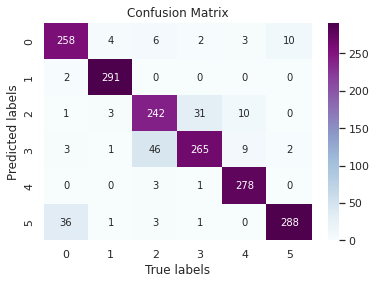

In [29]:
evaluate_prediction(clf, features_test, y_test)

In [30]:
print('Tempo per PCA:', round(pca_time,2), 'secondi')
print('Tempo necessario per il fitting del SVM dopo PCA:', round(fit_time_pca,2), 'secondi')

Tempo per PCA: 3.95 secondi
Tempo necessario per il fitting del SVM dopo PCA: 59.42 secondi


<p align='justify'>
Si può notare come il <i>tempo richiesto</i> per fittare il classificatore SVM si sia <i>notevolmente ridotto</i> dopo aver effettuato la PCA sulle features. 
Mentre dal punto di vista delle perfomance di classificazione la perdita risulta essere minima e ristretta soprattutto alle classi $0$ e $2$, nel complesso però se si analizza la metrica della <i> macro_avg </i> la differenza risulta essere minima rispetto al classificatore che utilizza tutti i dati.
</p>

### Feature extractor: block4_pool
<p align='justify'>
Provo ad analizzare ora cosa succede applicando il taglio in un punto intermedio dell'architettura, in particolare il punto scelto è il quarto blocco convoluzionale.
</p>

In [6]:
# cut in the middle of the model
model_cut2 = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
model_cut2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<p align='justify'>
Rispetto al punto di cutting precedente si nota come il numero di parametri trainabili è <b>diminuito sensibilmente</b> tuttavia la rappresentazione delle features avrà una <b>dimensione molto più elevata</b> pari a $14x14x512 = 100352$, quindi in questo caso sarà fondamentale l'applicazione della PCA. 
Prima di procedere con l'estrazione delle features elimino dalla memoria le vecchie variabili.
</p>

In [ ]:
del model_cut1, features, features_test, clf

In [8]:
start_time = time.time()
# extract feature for training set
features = model_cut2.predict(x_train)
# saving time for prediction
time_pred = (time.time() - start_time)

# extract feature for test set
features_test = model_cut2.predict(x_test)

# reshaping features dimension
final_dim = features.shape[1] * features.shape[2] * features.shape[3]
features = features.reshape((features.shape[0], final_dim))
features_test = features_test.reshape((features_test.shape[0], final_dim))

# check features shape (should have 100352 features for each image)
print(features.shape)

(3000, 100352)


<p align='justify'>
Una volta estratte le features, sia per training che per test set per semplicità dei passi successivi, procedo all'applicazione della PCA.
</p>

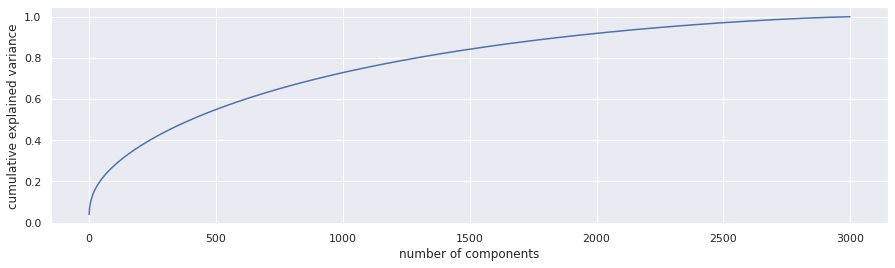

In [ ]:
# plotting pca cumulative explained variance
_ = check_pca(features)

<p align='justify'>
Dal grafico possiamo notare che con $1500$ features riusciamo ancora a spiegare un'ottima percentuale di varianza dei nostri dati $>80\%$, applico quindi la PCA mantenendo soltando questa dimensionalità per le features. Come nel caso precedente potevo evitare di plottare il grafo cumulato e applicare la PCA definendo la percentuale di varianza da spiegare desiderata.

In [9]:
start_time = time.time()

# define pca to keep only 1500 components
pca = PCA(n_components=1500, copy = False)  # alternative ---> pca = PCA(0.8)
# fit and apply pca to training set
features = pca.fit_transform(features)
# saving time needed for pca
pca_time = (time.time() - start_time)

# apply pca to test set
features_test = pca.transform(features_test)

print('new features shape:', features.shape)

new features shape: (3000, 1500)


<p align='justify'>
In questo caso la riduzione del numero di features era essenziale per poter trainare il classificatore.
</p>

In [10]:
# possibile parameters for grid search
param_grid = {'C': [1, 5, 10], 'gamma': ['auto', 'scale']}

# define a SVM with gridsearch
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

start_time = time.time()

# fitting with training features
clf = clf.fit(features, y_train)
# saving time for fitting
fit_time = (time.time() - start_time)

# check score for training set
print('Parametri trovati con GridSearchCV:', clf.best_params_)
print('Score raggiunto sul training set:', round(clf.best_score_, 4))

Parametri trovati con GridSearchCV: {'C': 10, 'gamma': 'scale'}
Score raggiunto sul training set: 0.8767


I parametri trovati dalla gridsearch sono diversi rispetto alla SVM precedente in cui era stato applicato PCA.

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       253
           1       0.98      0.93      0.96       317
           2       0.82      0.76      0.79       324
           3       0.83      0.80      0.81       310
           4       0.86      0.92      0.89       283
           5       0.91      0.87      0.89       313

    accuracy                           0.87      1800
   macro avg       0.87      0.87      0.87      1800
weighted avg       0.87      0.87      0.87      1800



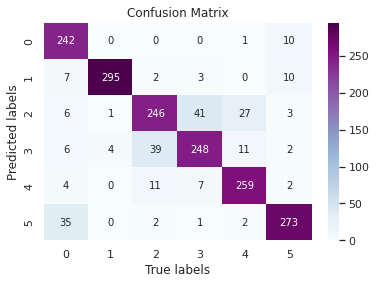

In [11]:
evaluate_prediction(clf, features_test, y_test)

In [12]:
print('Tempo necessario per la creazione delle features:', round(time_pred,2), 'secondi')
print('Tempo per PCA:', round(pca_time,2), 'secondi')
print('Tempo necessario per il fitting del SVM dopo PCA:', round(fit_time,2), 'secondi')

Tempo necessario per la creazione delle features: 85.1 secondi
Tempo per PCA: 216.48 secondi
Tempo necessario per il fitting del SVM dopo PCA: 174.14 secondi


<p align='justify'>
Possiamo notare come i risultati ottenuti con questo secondo cutting point risultino essere lievemente peggiori rispetto al caso precedente, i risultati hanno comunque score buoni. Questo perchè come detto il task è abbastanza simile a quello originale inoltre abbiamo un buon numero di immagini di training per il classificatore SVM. <br>
Per quanto riguarda i tempi richiesti si nota una riduzione per il tempo iniziale di creazione delle features, dovuto al minor numero di parametri presenti nel modello, mentre il tempo per la PCA e per SVM aumenta se confrontato con la PCA effettuata sul primo cutting point in quanto i parametri da considerare sono maggiori ($500$ vs $1500$).
</p>

### Feature extractor: block3_pool
<p align='justify'>
Provo ad analizzare ora cosa succede se il taglio viene effettuato ancora in un layer superiore. Inizialmente si era provato ad applicare il taglio a layer  <i> block2_pool </i> che però dava problemi di out of memory (OOM) durante la generazione delle features per il training set in quanto ogni immagine era rappresentata da $401408$ features. Per questo motivo ho optato per tagliare al layer <i> block3_pool </i>.
</p>

In [8]:
# cut in the middle of the model
model_cut3 = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)
model_cut3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<p align='justify'>
Rispetto al punto di cutting precedente si nota come il numero di parametri trainabili è ancora <b>diminuito</b> tuttavia la rappresentazione delle features avrà una <b>dimensione molto elevata</b> pari a $28x28x256 = 200704$. Questo richiede di gestire in modo più accurato la memoria se si vogliono usare tutte le immagini di training utilizzate per le altre casistiche. La soluzione più semplice e far ripartire la sessione colab, inoltre definisco le features soltanto per il traning set mentre il test set verrà gestito successivamente una volta trainato il classificatore SVM in modo da occupare il minor spazio possibile. 
</p>

In [9]:
start_time = time.time()
# extract feature for training set
features = model_cut3.predict(x_train)
# saving time for prediction
time_pred = (time.time() - start_time)

# prevent out of mem
del x_train

# reshaping features dimension
final_dim = features.shape[1] * features.shape[2] * features.shape[3]
features = features.reshape((features.shape[0], final_dim))

# check features shape (should have 200704 features for each image)
print(features.shape)

(3000, 200704)


<p align='justify'>
Una volta estratte le features procedo all'applicazione della PCA, in questo caso dato i problemi di memoria procedo in maniera automatica e quindi attraverso i parametri della libreria richiedo che venga preservato l'$80\%$ di varianza.
</p>

In [11]:
start_time = time.time()

# define pca to keep 80% of explainable variance
pca = PCA(0.8, copy = False) 
# fit and apply pca to training set
features = pca.fit_transform(features)
# saving time needed for pca
pca_time = (time.time() - start_time)

"""
# apply pca to test set
features_test = pca.transform(features_test)
"""

print('new features shape:', features.shape)

new features shape: (3000, 1369)


<p align='justify'>
In automatico le features sono state ridotte a $1369$ , anche in questo caso come in precedenza la riduzione del numero di features è essenziale per poter trainare il classificatore.
</p>

In [12]:
# possibile parameters for grid search
param_grid = {'C': [1, 5, 10], 'gamma': ['auto', 'scale']}

# define a SVM with gridsearch
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

start_time = time.time()

# fitting with training features
clf = clf.fit(features, y_train)
# saving time for fitting
fit_time = (time.time() - start_time)

# check score for training set
print('Parametri trovati con GridSearchCV:', clf.best_params_)
print('Score raggiunto sul training set:', round(clf.best_score_, 4))

Parametri trovati con GridSearchCV: {'C': 5, 'gamma': 'scale'}
Score raggiunto sul training set: 0.8363


<p align='justify'>
Anche in questo caso i parametri della SVM sono ancora differenti dal caso precedente con block4_pool. Elimino quindi dalla memoria le features riguardanti il tranining set e carico il test set su cui applico la stessa pca definita per il tranining.
</p>

In [17]:
# removing useless variable
del features

In [ ]:
# extract feature for test set
features_test = model_cut3.predict(x_test)

# prevent out of mem
del x_test
# reshaping features
features_test = features_test.reshape((features_test.shape[0], final_dim))

# apply pca to test set
features_test = pca.transform(features_test)

              precision    recall  f1-score   support

           0       0.74      0.91      0.81       244
           1       0.99      0.91      0.95       327
           2       0.80      0.74      0.77       325
           3       0.79      0.77      0.78       306
           4       0.83      0.84      0.84       297
           5       0.86      0.86      0.86       301

    accuracy                           0.84      1800
   macro avg       0.84      0.84      0.84      1800
weighted avg       0.84      0.84      0.84      1800



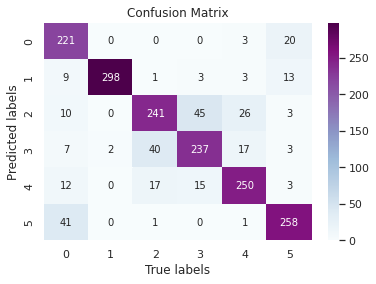

In [ ]:
evaluate_prediction(clf, features_test, y_test)

In [14]:
print('Tempo necessario per la creazione delle features:', round(time_pred,2), 'secondi')
print('Tempo per PCA:', round(pca_time,2), 'secondi')
print('Tempo necessario per il fitting del SVM dopo PCA:', round(fit_time,2), 'secondi')

Tempo necessario per la creazione delle features: 41.47 secondi
Tempo per PCA: 677.65 secondi
Tempo necessario per il fitting del SVM dopo PCA: 182.64 secondi


<p align='justify'>
In questo caso i risultati peggiorano ulteriormente soprattuto nella classe $2$ anche se in generale tutte le classi segnalano dei peggioramenti rispetto alla feature extraction a <i>block4_pool</i>. Inoltre questa casistica ha richiesto un notevole tempo computazionale per il fitting della PCA sulle features del traning set e anche una particolare gestione della memoria per evitare problematica di OOM. <br>
In generale possiamo ritenere questa classificazione equalmente valida rispetto a quella precedente, tuttavia l'aumento dei tempi e la gestione della memoria richiesta mi fa propendere di più all'utilizzo del precedente cutting point.
</p>

### Final considerations
<p align='justify'>
In generale si è visto che i livelli più alti richiedono molto tempo per la creazione delle features però permetto una classificazione molto accurata, con il $92\%$ di macro_avg. Risalendo invece il modello e quindi applicando il cutting sui primi layer si è visto come le features aumentano di numero richiendo quindi un'applicazione della PCA per poter essere utilizzate nel classificatore SVM, inoltre le performance sembrano calare ad ogni step.

In [4]:
# download notebook in .html extension
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment4/Assignment4.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment4/Assignment4.ipynb to html
[NbConvertApp] Writing 692357 bytes to /content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment4/Assignment4.html
